In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
customer_df = pd.read_csv("csv/mall_customers.csv")

# Data Cleaning

In [4]:
def remove_null(df):
    """
        This function takes our dataframe, 
        drops the rows with unavailable values 
        (nans) and returns the dataframe
    """
    
    for i, row in df.iterrows():
        if row.isna().any():
            df = df.dropna()

    return df

In [5]:
def rename_columns(df):
    """
        This function renames and re-orders 
        the columns in our dataframe for 
        easier indexing and creates new 
        rows by column operations
    """
    
    labels = ["10 - 19", "20 - 29", "30 - 39", 
              "40 - 49", "50 - 59", "60 - 69", "70+"]

    ranges = [10, 19, 29, 39, 49, 59, 69, np.inf]

    gender_dict = {"Male": 1, "Female": 2}

    df["gender_class"] = df["Gender"].replace(gender_dict)

    df["Age_group"] = pd.cut(customer_df["Age"], 
                             bins = ranges, 
                             labels = labels
                             )

    df["Annual Income (k$)"] = df["Annual Income (k$)"] * 1000

    df["total_amount"] = ((df["Annual Income (k$)"]) 
                          * (df["Spending Score (1-100)"] / 100))

    new_order = ['CustomerID', 'Age', 'Annual Income (k$)', 
                 'Spending Score (1-100)', 'total_amount', 
                 'gender_class', 'Gender', 'Age_group']

    df = df[new_order]

    new_column_names = {'CustomerID': 'customer_id', 'Age': 'age', 
                        'Annual Income (k$)': 'annual_income', 
                        'Spending Score (1-100)': 'spending_score', 
                        'Gender': 'gender', 'Age_group': 'age_group'}

    df = df.rename(columns = new_column_names)

    return df

In [5]:
def remove_duplicates(df):
    """
        This function drops duplicate 
        data in our dataframe
    """
    
    newdf = df.drop_duplicates(subset = ["age", 
                                         "gender", 
                                         "spending_score"], 
                               keep = "first")

    newdf = newdf.drop_duplicates(subset = ["age", 
                                            "gender", 
                                            "annual_income"],
                                  keep = "last")

    return newdf

In [6]:
def remove_outliers(df):
    """
        This function querys out dataframe and 
        select only the data that has no outliers
    """
    newdf = df.query("spending_score > 9 & annual_income < 70000")
    newdf = newdf.drop([123]) # A manually detected outlier.

    return newdf

In [34]:
def cleanse(df):
    no_null_df = remove_null(df)
    renamed_df = rename_columns(no_null_df)
    unique_df = remove_duplicates(renamed_df)
    clean_df = remove_outliers(unique_df)
    return clean_df

In [44]:
def plot_sized_scatter(df, xdata, ydata):
    plt.figure(dpi = 100)

    sns.scatterplot(
        data = df, x = xdata, y = ydata, hue = "gender",
        size = "age_group", zorder = 2, sizes=(100, 20), alpha = 0.7
    )

    plt.grid(zorder = 0, alpha = 0.3)

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.02))

    plt.title("Customer Ids by their Spending Score")

    plt.savefig("CustomerId_vs_Spending_Score")

    plt.show()
# plot_sized_scatter(cdf, "customer_id", "spending_score")

In [58]:
# Plot of customer id vs spending score
def plot_scatter(df, xdata, ydata, ymin, ymax, xlabel, ylabel, title):
    plt.figure(dpi = 100)

    sns.scatterplot(
        data = df, x = xdata, y = ydata, hue = "age_group",
        zorder = 2, alpha = 0.7
    )

    plt.grid(zorder = 0, alpha = 0.3)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.ylim(ymin, ymax)

    plt.legend(loc = 'upper right', bbox_to_anchor = (1.25, 1.02))

    plt.title(title)

    plt.savefig(title)

    plt.show()

# x = cdf["customer_id"]
# y = cdf["age"]

# plot_scatter(cdf, x, y, 0, 80, "Customer ID", "Age", "Customers by their Age")

# x = cdf["age"]
# y = cdf["spending_score"]

# plot_scatter(cdf, x, y, 0, 105, "Customer Age", "Spending Score", "Customer Age by their Spending Score")

In [66]:
def plot_hist(df, labels):

    plt.figure(dpi = 100)

    plt.grid(zorder = 0, alpha = 0.3)

    plt.hist(df["age_group"], zorder = 2, bins = len(labels), alpha = 0.85, edgecolor = "white")

    plt.xlabel("Age Intervals")
    plt.ylabel("Frequency")

    plt.title("Distribution of Age Groups")

    plt.xticks(rotation = 45)

    plt.show()

In [9]:
cdf = customer_df.copy()
cdf = cleanse(cdf)

In [11]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 122
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     116 non-null    int64   
 1   age             116 non-null    int64   
 2   annual_income   116 non-null    int64   
 3   spending_score  116 non-null    int64   
 4   total_amount    116 non-null    float64 
 5   gender_class    116 non-null    int64   
 6   gender          116 non-null    object  
 7   age_group       116 non-null    category
dtypes: category(1), float64(1), int64(5), object(1)
memory usage: 7.7+ KB


In [26]:
cdf.describe(include = "category")

,age_group
count,116
unique,7
top,20 - 29
freq,29


In [82]:
age_skew = ss.skew(cdf["age"])
income_skew = ss.skew(cdf["annual_income"])
score_skew = ss.skew(cdf["spending_score"])

In [74]:
age_kurt = ss.kurtosis(cdf["age"])
income_kurt = ss.kurtosis(cdf["annual_income"])
score_kurt = ss.kurtosis(cdf["spending_score"])

In [81]:
print(f"The average age is: {cdf['age'].mean()}")
print(f"The standard deviation for age is: {cdf.age.std()}")
print(f"The skewness of the age distribution is: {age_skew}")
print(f"The Kurtosis of the age distribution is: {age_kurt}")

The average age is: 39.8448275862069
The standard deviation for age is: 16.06541164347689
The skewness of the age distribution is: 0.31106877473884875
The Kurtosis of the age distribution is: -1.1336215058057897


In [84]:
print(f"The average income is: {cdf['annual_income'].mean()}")
print(f"The standard deviation for income is: {cdf.annual_income.std()}")
print(f"The skewness of the income distribution is: {income_skew}")
print(f"The Kurtosis of the income distribution is: {income_kurt}")

The average income is: 45172.41379310345
The standard deviation for income is: 15721.641612519468
The skewness of the income distribution is: -0.3866341330241227
The Kurtosis of the income distribution is: -1.071062489360395


In [86]:
print(f"The average spending score is: {cdf['spending_score'].mean()}")
print(f"The standard deviation for spending score is: {cdf.spending_score.std()}")
print(f"The skewness of the spending score distribution is: {score_skew}")
print(f"The Kurtosis of the spending score distribution is: {score_kurt}")

The average spending score is: 52.172413793103445
The standard deviation for spending score is: 17.304573842255376
The skewness of the spending score distribution is: 0.36028742306662037
The Kurtosis of the spending score distribution is: 0.7251704322102963


In [64]:
# Histogram plot of customers by their age groups 
labels = ["10 - 19", "20 - 29", "30 - 39", 
            "40 - 49", "50 - 59", "60 - 69", "70+"]

groups_label = cdf["age_group"].unique()

# print(groups_label)

age_sorted = cdf.sort_values(by = 'age_group', ascending = True)

# plot_hist(age_sorted, labels)

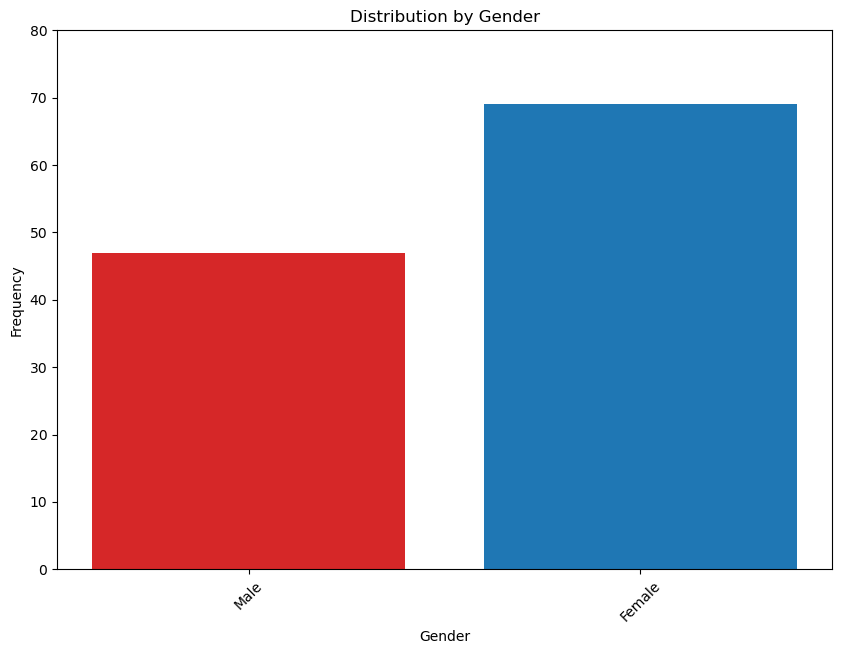

In [69]:
# Histogram plot of customers by their gender 

plt.figure(figsize = (10, 7))

gender = cdf["gender"].unique()
count = [len(cdf[cdf["gender"] == "Male"]), len(cdf[cdf["gender"] == "Female"])]
bar_colors = ['tab:red', 'tab:blue']

plt.bar(gender, count, label = gender, color = bar_colors)

plt.xlabel("Gender")
plt.ylabel("Frequency")

plt.title("Distribution by Gender")

plt.savefig("gender_dist")

plt.xticks(rotation = 45)
plt.yticks(np.linspace(0, 80, 9))

plt.show()

In [21]:
cdf

,customer_id,age,annual_income,spending_score,total_amount,gender_class,gender,age_group
0,1,19,15000,39,5850.0,1,Male,10 - 19
1,2,21,15000,81,12150.0,1,Male,20 - 29
3,4,23,16000,77,12320.0,2,Female,20 - 29
4,5,31,17000,40,6800.0,2,Female,30 - 39
5,6,22,17000,76,12920.0,2,Female,20 - 29
...,...,...,...,...,...,...,...,...
118,119,51,67000,43,28810.0,2,Female,50 - 59
119,120,50,67000,57,38190.0,2,Female,50 - 59
120,121,27,67000,56,37520.0,1,Male,20 - 29
121,122,38,67000,40,26800.0,2,Female,30 - 39


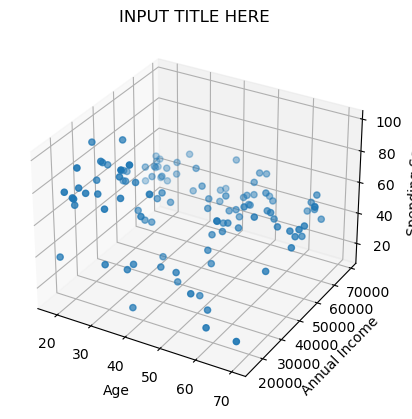

In [25]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(cdf["age"], cdf["annual_income"], cdf["spending_score"], marker = "o")

plt.title("INPUT TITLE HERE")

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income')
ax.set_zlabel('Spending Score')

# plt.savefig("3d_plot_for_age_income_spending")

plt.show()

In [87]:
# Correlation matrix and confusion matrix

figures = cdf.iloc[:, 1:5]
gen_fig = cdf.iloc[:, [1, 2, 3, 4, 6]]
corr_matrix = figures.corr(method = "pearson")
corr_matrix

,age,annual_income,spending_score,total_amount
age,1.000000,0.228454,-0.381825,-0.000055
annual_income,0.228454,1.000000,-0.163578,0.788853
spending_score,-0.381825,-0.163578,1.000000,0.423914
total_amount,-0.000055,0.788853,0.423914,1.000000


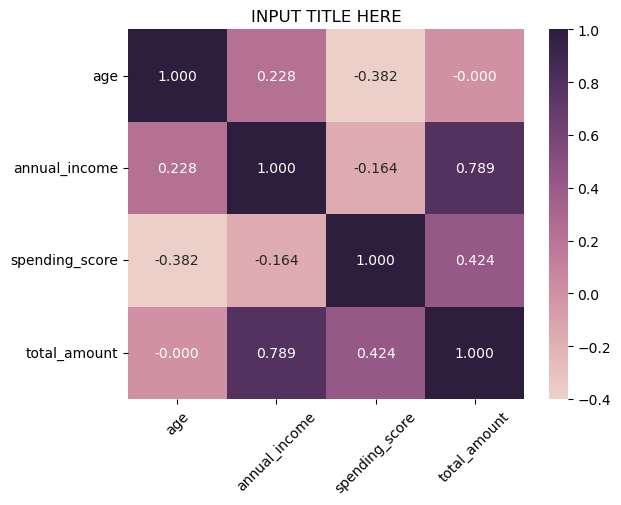

In [88]:
%matplotlib inline
sns.heatmap(corr_matrix, cmap=sns.cubehelix_palette(as_cmap = True), vmin = -0.4, vmax = 1, annot = True, fmt=".3f")

plt.xticks(rotation = 45)

plt.title("INPUT TITLE HERE")

# plt.savefig("correlation_martrix")

plt.show()

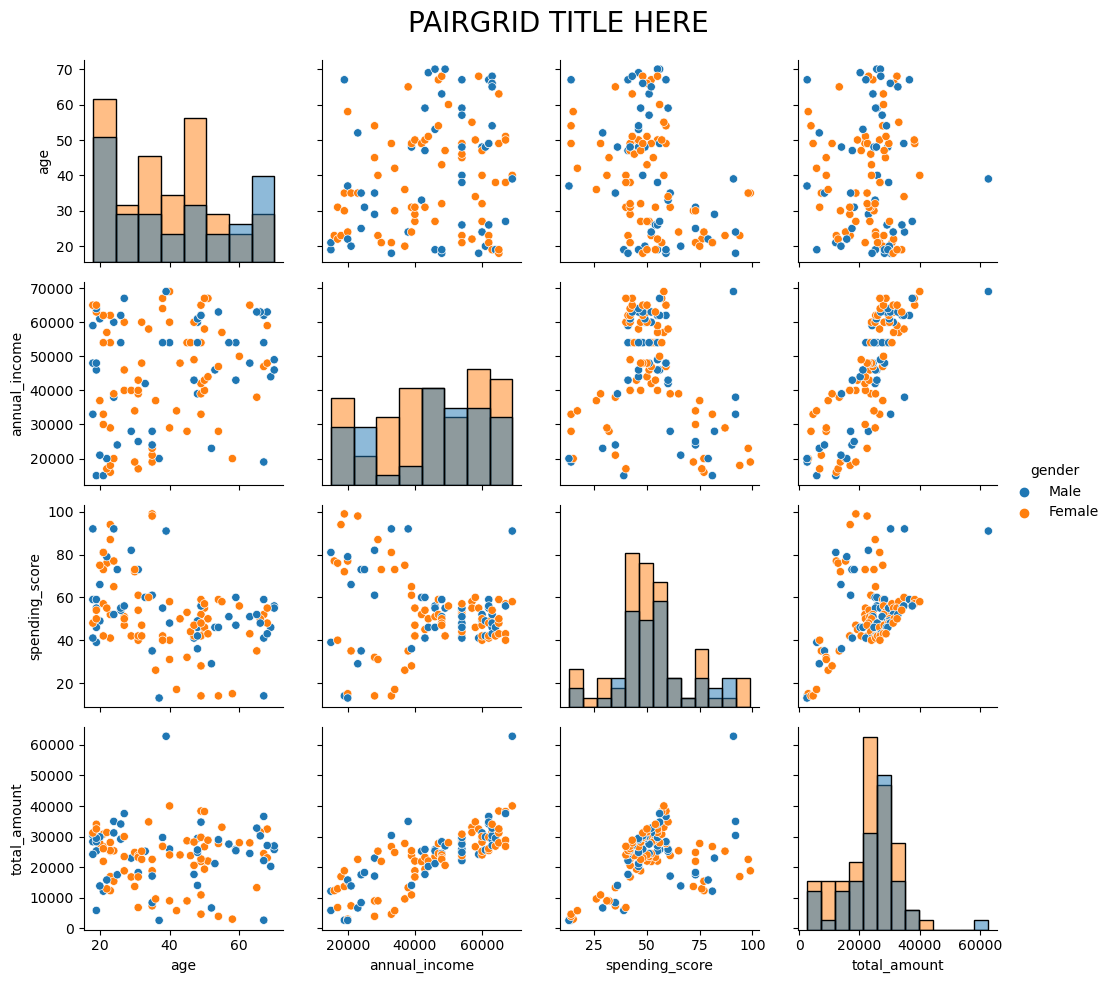

In [89]:
# Pairplot
g = sns.PairGrid(gen_fig, hue = 'gender')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

g.figure.suptitle("PAIRGRID TITLE HERE", size = 20)
plt.subplots_adjust(top = 0.93)
g.add_legend()

# plt.savefig("pairgrid")

plt.show()

In [675]:
# Let's start clustering

# sns

In [27]:
# Let's start model fitting on annual income vs total spending

def linfunc(x, d, e, f, g):
    """ Function for fitting a straight line, for curve_fit
        x: independent variable
        a, b: parameters to be fitted
    """
    y = (d * (x ** 3)) + (e * (x ** 2)) + (f * x) + g
    return y

In [28]:
inc = cdf["annual_income"]
spending = cdf["total_amount"]

p, cov = curve_fit(linfunc, inc, spending)  # give it the function to be fitted then x and y

# the errors are the square root of the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(cov))

print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}")
print(f"c = {p[2]:.2f} +/- {sigma[2]:.2f}")
print(f"d = {p[3]:.2f} +/- {sigma[3]:.2f}")

a = 0.00 +/- 0.00
b = -0.00 +/- 0.00
c = 0.69 +/- 0.89
d = 34.16 +/- 10476.38


In [29]:
p_np = Poly.fit(inc, spending, 3)  # Polynomial just needs inc, spending data and the number of degrees
cov = np.polyfit(inc, spending, 3, cov = True)[1]  # need a separate call as numpy devs have still not merged
sigma_np = np.sqrt(np.diag(cov))

d, c, b, a = p_np.convert().coef  # note the opposite order of coefficients
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")
print(f"c = {c:.2f} +/- {sigma_np[2]:.2f}")
print(f"d = {d:.2f} +/- {sigma_np[3]:.2f}")

a = 0.00 +/- 0.00
b = -0.00 +/- 0.00
c = 0.69 +/- 0.89
d = 34.16 +/- 10476.37


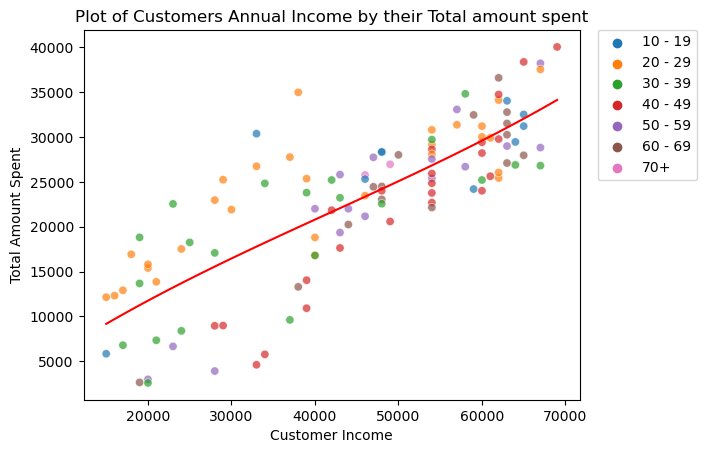

In [30]:
# Fitting plot on customer income vs total amount spent

plt.figure(dpi = 100)

sns.scatterplot(
    data = cdf, x = inc, y = spending, hue = "age_group",
    sizes=(20, 200), alpha = 0.7
)

xfit = np.linspace(np.min(inc), np.max(inc), 100)
plt.plot(xfit, linfunc(xfit, p[0], p[1], p[2], p[3]), 'r-')

plt.xlabel("Customer Income")
plt.ylabel("Total Amount Spent")

# plt.ylim(0, 80)

plt.legend(loc = 'upper right', bbox_to_anchor = (1.25, 1.02))

plt.title("Plot of Customers Annual Income by their Total amount spent")

# plt.savefig("customer_income_by_age_fit")

plt.show()

a = 0.01 +/- 0.00
b = -2.92 +/- 0.50
c = 203.81 +/- 38.69
d = -4806.21 +/- 1189.07
e = 38263.64 +/- 11837.69


a = 0.01 +/- 0.00
b = -2.92 +/- 0.50
c = 203.81 +/- 38.69
d = -4806.21 +/- 1189.07
e = 38263.64 +/- 11837.70




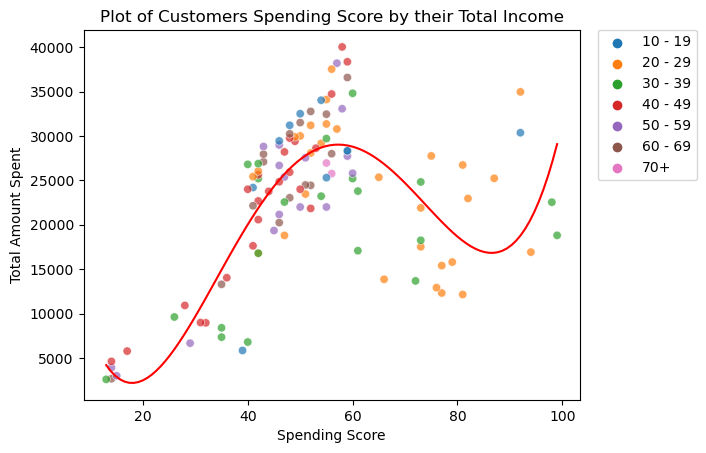

In [31]:
# Let's start model fitting on annual income vs total spending

def linfunc(x, a, b, c, d, e):
    """ 
        Function for fitting a 4 degree polynomial, for curve_fit
        x: independent variable
        a, b, c, d, e: parameters to be fitted
    """
    y = (a * (x ** 4)) + (b * (x ** 3)) + (c * (x ** 2)) + (d * x) + e
    return y

inc = cdf["spending_score"]
spending = cdf["total_amount"]

p, cov = curve_fit(linfunc, inc, spending)  

sigma = np.sqrt(np.diag(cov))

print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}")
print(f"c = {p[2]:.2f} +/- {sigma[2]:.2f}")
print(f"d = {p[3]:.2f} +/- {sigma[3]:.2f}")
print(f"e = {p[4]:.2f} +/- {sigma[4]:.2f}\n\n")

p_np = Poly.fit(inc, spending, 4)
cov = np.polyfit(inc, spending, 4, cov = True)[1]
sigma_np = np.sqrt(np.diag(cov))

e, d, c, b, a = p_np.convert().coef
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")
print(f"c = {c:.2f} +/- {sigma_np[2]:.2f}")
print(f"d = {d:.2f} +/- {sigma_np[3]:.2f}")
print(f"e = {e:.2f} +/- {sigma_np[4]:.2f}\n\n")

# Fitting plot on customer income vs total amount spent

plt.figure(dpi = 100)

sns.scatterplot(
    data = cdf, x = inc, y = spending, hue = "age_group",
    sizes=(20, 200), alpha = 0.7
)

xfit = np.linspace(np.min(inc), np.max(inc), 100)
plt.plot(xfit, linfunc(xfit, p[0], p[1], p[2], p[3], p[4]), 'r-')

plt.xlabel("Spending Score")
plt.ylabel("Total Amount Spent")

# plt.ylim(0, 80)

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02))

plt.title("Plot of Customers Spending Score by their Total Income")

# plt.savefig("customers_spending_by_total_income_fit")

plt.show()

In [32]:
np.max(inc)

99

a = 0.45 +/- 0.03
b = 2827.60 +/- 1473.99


a = 0.45 +/- 0.03
b = 2827.60 +/- 1473.99


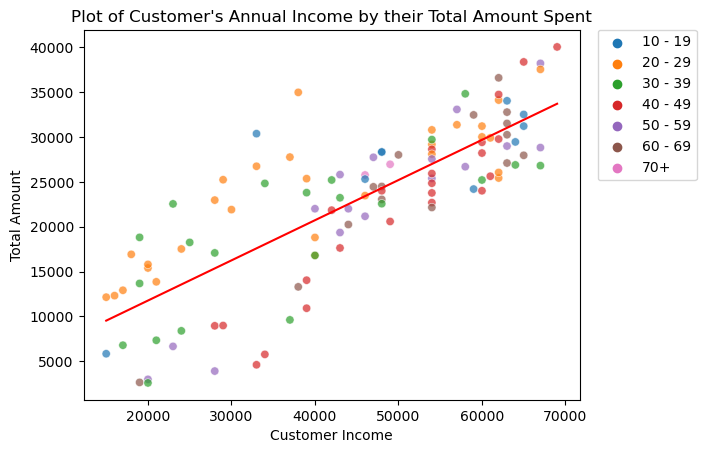

In [34]:
# Let's start model fitting on annual income vs total spending

def linfunc(x, a, b):
    """ Function for fitting a straight line, for curve_fit
        x: independent variable
        a, b: parameters to be fitted
    """
    y = (a * x) + b
    return y

inc = cdf["annual_income"]
spending = cdf["total_amount"]

p, cov = curve_fit(linfunc, inc, spending)

sigma = np.sqrt(np.diag(cov))

print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}\n\n")

p_np = Poly.fit(inc, spending, 1)
cov = np.polyfit(inc, spending, 1, cov = True)[1]
sigma_np = np.sqrt(np.diag(cov))

b, a = p_np.convert().coef
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")

# Fitting plot on customer income vs total amount spent

plt.figure(dpi = 100)

sns.scatterplot(
    data = cdf, x = inc, y = spending, hue = "age_group",
    sizes=(20, 200), alpha = 0.7
)

xfit = np.linspace(np.min(inc), np.max(inc), 100)
plt.plot(xfit, linfunc(xfit, p[0], p[1]), 'r-')

plt.xlabel("Customer Income")
plt.ylabel("Total Amount")

# plt.ylim(0, 80)

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02))

plt.title("Plot of Customer's Annual Income by their Total Amount Spent")

# plt.savefig("total_amount_income_fit")

plt.show()

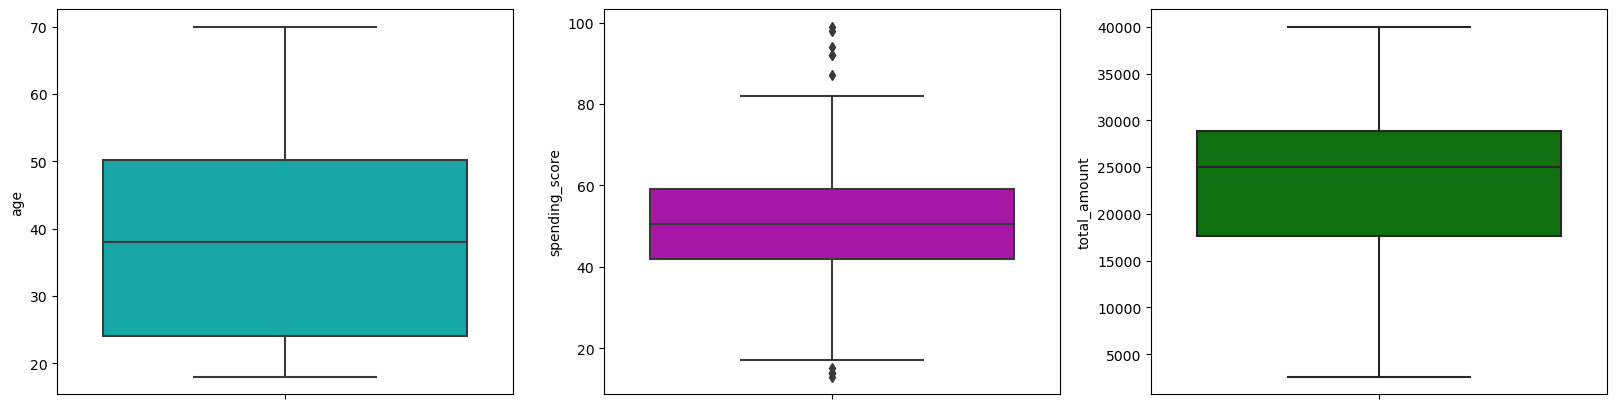

In [683]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

sns.boxplot(y = "age", palette = ["c"], data = cdf, ax = ax[0])
sns.boxplot(y = "spending_score", palette = ["m"], data = cdf, ax = ax[1])
sns.boxplot(y = "total_amount", palette = ["g"], data = cdf, ax = ax[2])

# plt.savefig("age_score_total_boxplot")

plt.show()

In [123]:
x = customer_df["Spending Score (1-100)"]
y = customer_df["Annual Income (k$)"]

# x = cdf["spending_score"]
# y = cdf["annual_income"]

def create_clusters(x, y):
    xy = np.column_stack((x, y))

    ncluster = 5
    # set up the clusterer with the number of expected clusters (by eye)
    # kmeans starts with a random seed and repeats the clustering n_init times.
    kmeans = KMeans(n_clusters = ncluster, n_init = 200)

    # Fit the data, results are stored in the kmeans object
    kmeans.fit(xy)     # fit done on x,y pairs

    labels = kmeans.labels_  # the group for each fitted point
        
    # the estimated cluster centres
    cen = kmeans.cluster_centers_
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]

    return xkmeans, ykmeans


In [128]:
def plot_fitted_clusters(xkmeans, ykmeans):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    fig, ax = plt.subplots(dpi = 144)
    
    # Plot data points with different colors based on their cluster labels
    s = ax.scatter(x, y, c = labels, s = 10, cmap = 'Set1', marker = 'o', label = 'Data')

    # Plot the estimated cluster centers
    ax.plot(xkmeans, ykmeans, 'k+', ms = 10, label = 'Estimated Centres')

    # Add colorbar to show the mapping of cluster labels to colors
    cbar = fig.colorbar(s, ax = ax)
    cbar.set_ticks(np.unique(labels))
    
    ax.set_ylim(0, 170)

    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


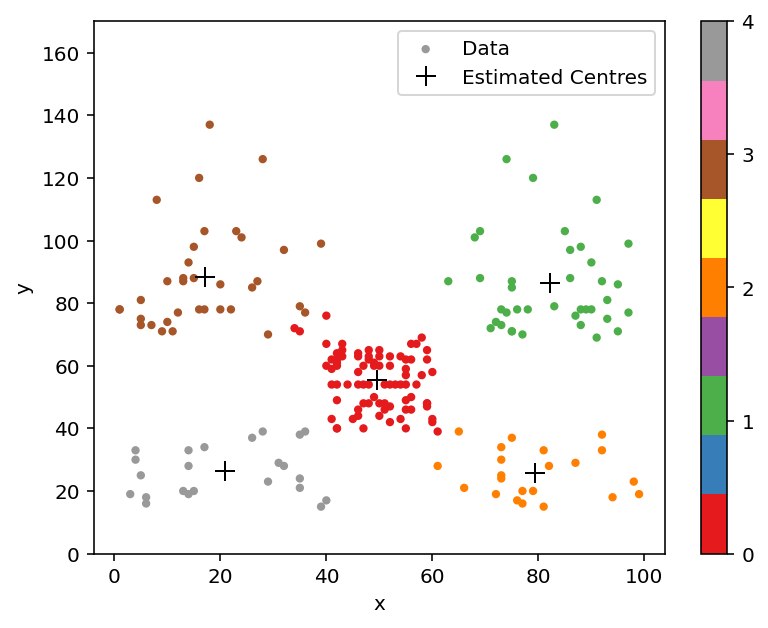

In [129]:
xkmeans, ykmeans = create_clusters(x, y)
plot_fitted_clusters(xkmeans, ykmeans)

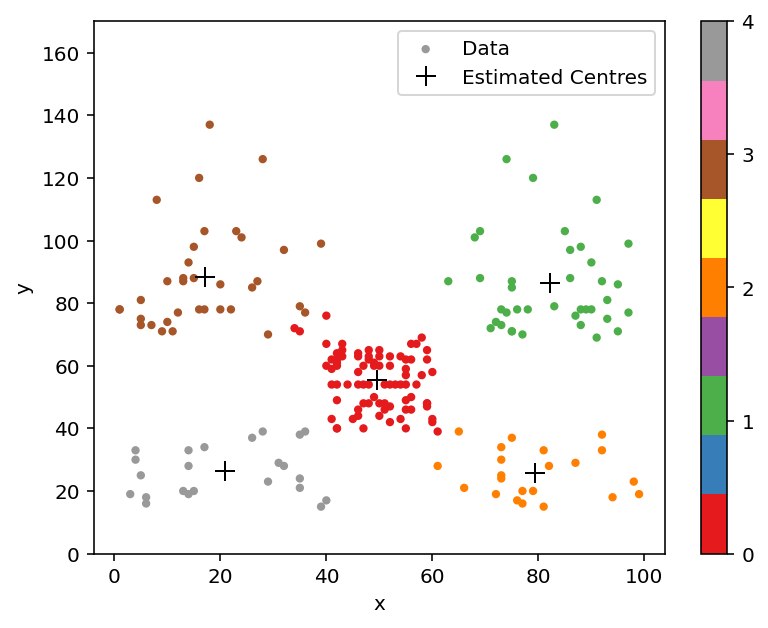

In [148]:
plot_fitted_clusters(xkmeans, ykmeans)

In [93]:
def plot_fitted_clusters():
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    fig, ax = plt.subplots(dpi = 144)
    s = ax.scatter(x, y, marker = 'o', label = 'Data')

    ax.plot(xkmeans, ykmeans, 'bs', ms = 10, label = 'Estimated Centres')

    cbar = fig.colorbar(s, ax = ax)
    # cbar.set_ticks(np.unique(nclust))
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    return

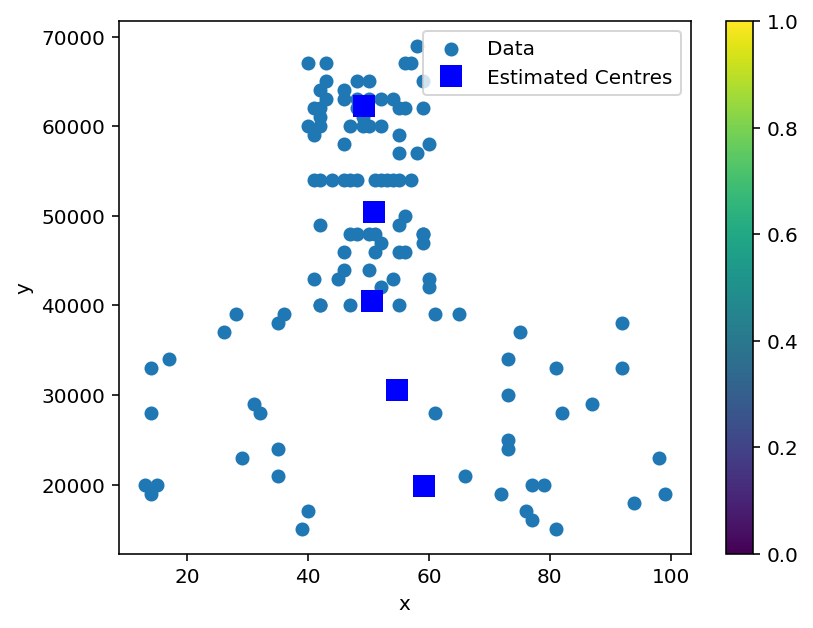

In [94]:
plot_fitted_clusters()

In [111]:
silhouette_score(xy, labels)

0.553931997444648

In [112]:
def one_silhoutte(n, xy):
    """ 
    Calculates the silhoutte score for n clusters 
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters = n, n_init = 20)
    # Fit the data
    kmeans.fit(xy)
    labels = kmeans.labels_
    
    # calculate the silhoutte score
    score = silhouette_score(xy, labels)

    return score

In [113]:
best_n, best_score = None, -np.inf
for n in range(3, 9):  # 2 to 10 clusters
    score = one_silhoutte(n, xy)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")

print(f"Best number of clusters = {best_n:2g}")

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 3 clusters silhoutte score = 0.47


C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 4 clusters silhoutte score = 0.49


C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 5 clusters silhoutte score = 0.55


C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 6 clusters silhoutte score = 0.54


C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 7 clusters silhoutte score = 0.53


C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 8 clusters silhoutte score = 0.45
Best number of clusters =  5


In [114]:
def plot_elbow_method(min_k, max_k, wcss, best_n):
    """
    Plots the elbow method between min_k and max_k
    """
    fig, ax = plt.subplots(dpi = 144)
    ax.plot(range(min_k, max_k + 1), wcss, 'kx-')
    ax.scatter(best_n, wcss[best_n - min_k], marker = 'o', color = 'red', facecolors = 'none', s = 50)
    ax.set_xlabel('k')
    ax.set_xlim(min_k, max_k)
    ax.set_ylabel('WCSS')
    plt.show()
    return

C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

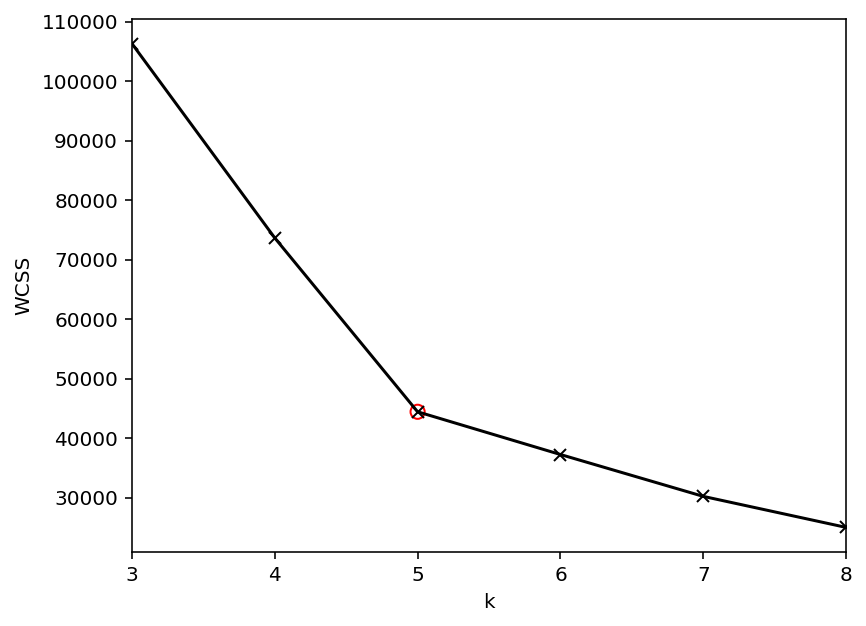

In [115]:
wcss = []
for n in range(3, 9):
    kmeans = KMeans(n_clusters = n, n_init = 20)
    kmeans.fit(xy)
    wcss.append(kmeans.inertia_)

plot_elbow_method(3, 8, wcss, best_n)